<a href="https://colab.research.google.com/github/luigiselmi/dl_tensorflow/blob/main/epfl_building_footprints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rooftop detection
We use the data from [Cadei et al - Detecting available rooftop area from satellite images to install photovoltaic panels](https://github.com/riccardocadei/photovoltaic-detection/tree/main) to implement a semantic segmentation model for the extraction of building footprints from satellite images.

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
from skimage import io
from skimage import exposure
from skimage.io import imsave, imread
import warnings
warnings.filterwarnings('ignore')


In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
p = Path('/content/drive/MyDrive/EPFL_Building_Footprints/data/all/train/')
paths = []
[paths.append(sub_folder) for sub_folder in p.iterdir() if sub_folder.is_dir()]

[None, None]

In [4]:
labels_path = paths[0]
images_path = paths[1]

In [5]:
def create_list(raster_path):
    """
    This function extracts the raster file paths (png images or masks) in the
    folder path and puts them in a list. The list is sorted in order to have
    each image and mask with the same index
    """
    img_list = []
    for file in os.listdir(raster_path):
        if file.endswith(".png"):
            img_list.append(os.path.join(raster_path, file))

    return sorted(img_list)

In [6]:
footprints_list = create_list(images_path)
len(footprints_list)

420

In [7]:
print(footprints_list[0])

/content/drive/MyDrive/EPFL_Building_Footprints/data/all/train/images/DOP25_LV03_1301_11_2015_1_15_497500.0_119062.5.png


In [8]:
img_0 = io.imread(footprints_list[0])
img_0.shape

(250, 250, 3)

In [9]:
def plot_raster(ax, list_images):
  index = 0
  for col in range(0, fig_cols):
    for row in range(0, fig_rows):
      img_natcol = io.imread(list_images[index])
      img_equalized = exposure.equalize_hist(img_natcol)
      ax[row, col].set_axis_off()
      ax[row, col].imshow(img_equalized)
      index += 1

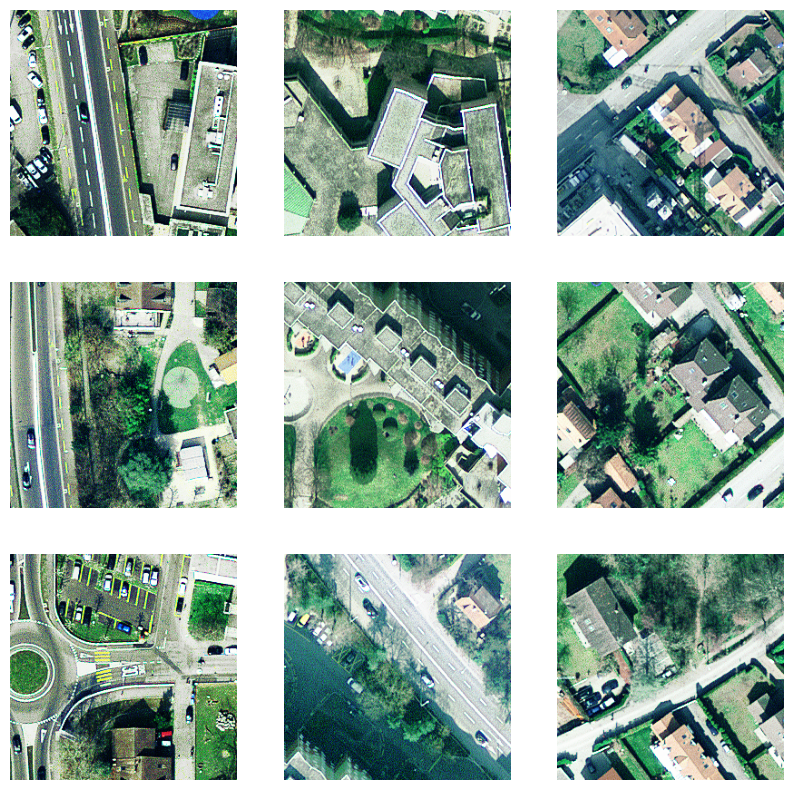

In [10]:
fig_rows = 3
fig_cols = 3
fig, ax = plt.subplots(nrows=fig_rows, ncols=fig_cols, figsize=(10, 10))
plot_raster(ax, footprints_list)


In [11]:
labels_list = create_list(labels_path)
len(labels_list)

420

In [12]:
print(labels_list[0])

/content/drive/MyDrive/EPFL_Building_Footprints/data/all/train/labels/DOP25_LV03_1301_11_2015_1_15_497500.0_119062.5_label.png


In [13]:
label_0 = io.imread(labels_list[0])
label_0.shape

(250, 250, 3)

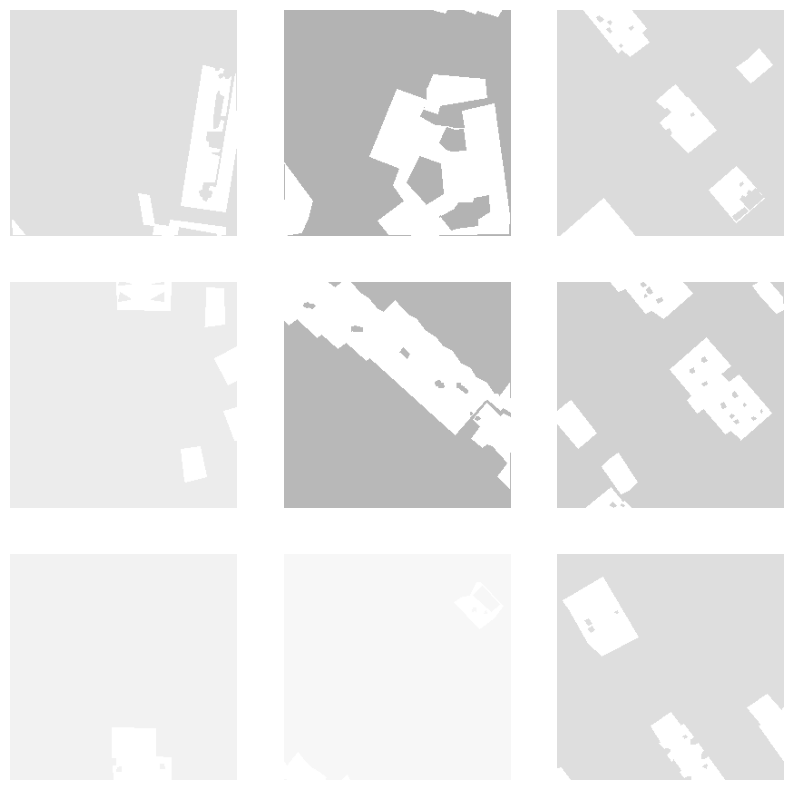

In [14]:
fig, ax = plt.subplots(nrows=fig_rows, ncols=fig_cols, figsize=(10, 10))
plot_raster(ax, labels_list)

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array

In [16]:
import random
img_size = (200, 200)
num_imgs = len(footprints_list)
random.Random(1337).shuffle(footprints_list)
random.Random(1337).shuffle(labels_list)

In [17]:
def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

In [18]:
def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

In [36]:
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(footprints_list[i])
    targets[i] = path_to_target(labels_list[i])

In [61]:
input_imgs[0].min()

2.0

In [62]:
targets[0].min(), targets[0].max()

(254, 255)

In [37]:
num_val_samples = 100
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [41]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    model = keras.Model(inputs, outputs)
    return model

In [56]:
model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling_5 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 100, 100, 64)      1792      
                                                                 
 conv2d_36 (Conv2D)          (None, 100, 100, 64)      36928     
                                                                 
 conv2d_37 (Conv2D)          (None, 50, 50, 128)       73856     
                                                                 
 conv2d_38 (Conv2D)          (None, 50, 50, 128)       147584    
                                                                 
 conv2d_39 (Conv2D)          (None, 25, 25, 256)       2951

In [57]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")
callbacks = [
    keras.callbacks.ModelCheckpoint("rooftop_segmentation.keras",
    save_best_only=True)
]

In [58]:
history = model.fit(train_input_imgs, train_targets,
                    epochs=20,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/20


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (64, 200, 200, 1) and (64, 200, 200, 3) are incompatible
